In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [26]:
import glob
import re
import time

import numpy as np
# import seaborn as sns

from sklearn.metrics import adjusted_rand_score

In [47]:
def load_history(fpath):
    mod = []
    nclusts = []
    with open(fpath, 'r') as f:
        for line in f:
            m = re.match(r'Starting step (\d+), n=(\d+), modularity: (.*)', line)
            if m is not None:
                it, n, m = m.groups()
                mod.append(float(m))
                nclusts.append(n)
    return nclusts, mod

In [4]:
def load_clusterings(fpath):
    levels = []
    with open(fpath, 'r') as f:
        it = iter(f)
        while True:
            try:
                line = next(it)
                if line.startswith('# Level'):
                    n = int(next(it).strip())
                    levels.append(np.zeros((n,), dtype=np.int32))
                    i = 0
                else:
                    levels[-1][i] = int(line.strip())
                    i += 1
            except StopIteration:
                break
    return levels

def score_clustering(clusts, gtruth):
    c = np.copy(clusts[0])
    g = np.copy(gtruth[0])
    scores = [adjusted_rand_score(c, g)]
    
    for l in range(1, min(len(clusts), len(gtruth))):
        # Translate each to the next level
        map_c = {low:hi for low,hi in enumerate(clusts[l])}
        map_g = {low:hi for low,hi in enumerate(gtruth[l])}
        for i in xrange(c.shape[0]):
            c[i] = map_c[c[i]]
            g[i] = map_g[g[i]]
        scores.append(adjusted_rand_score(c, g))
    return scores

def score_clustering_best_match(clusts, gtruth):
    c = np.copy(clusts[0])
    g = np.copy(gtruth[0])
    scores = []
    
    def maybe_remap(it, c, all_c):
        if it == 0:
            return
        map_ = {low:hi for low,hi in enumerate(all_c[it])}
        for i in xrange(c.shape[0]):
            c[i] = map_[c[i]]
    
    for li in range(len(gtruth)-1):
        lvl_scores = []
        c = np.copy(clusts[0])
        maybe_remap(li, g, gtruth)
        
        for lj in range(len(clusts)):
            maybe_remap(lj, c, clusts)
            lvl_scores.append(adjusted_rand_score(c, g))
        if li == len(gtruth) - 1:
            assert np.sum(g == g[0]) == g.shape[0]
            scores.append(1.0)
        else:
            scores.append(max(lvl_scores))
    return scores

def get_peak_modularity(log_fpath):
    with open(log_fpath, 'r') as f:
        for line in f:
            pass
    return float(line.split()[-1])

def alg_name(clusts_fpath):
    name = '.'.join(clusts_fpath.split('.')[4:8])
    name = name.replace('.clusts', '').replace('bin.', '')
    return name

In [40]:
graphs = sorted(glob.glob('../beyond/exp_arxiv/*.bin'))
algs = [alg_name(f) for f in sorted(glob.glob(graphs[0] + '*.clusts'))]

In [6]:
# Map algs to colors
num_louv = len([a for a in algs if 'louv' in a])
color_seq_iter = iter(cm.winter(np.linspace(0,1,num_louv)))
# color_seq_iter = iter(cm.Paired(np.linspace(0,1,num_louv)))
colors = {alg: next(color_seq_iter) for alg in algs if 'louv' in alg}
color_diver_iter = iter(cm.Set1(np.linspace(0,1,10)))
colors.update(
    {alg: next(color_diver_iter) for alg in algs if 'louv' not in alg}
)

In [7]:
# Key: Experiments
# ================
# - g0 denotes graphs sampled from a perfect binary tree
#    - c=XXX is leaf cluster size
#    - p=XXX is leaf cluster edge probability
#    - d=XXX denotes pbb decay when going up the tree (default d=2.0 halves the probability)
#    - h=XXX is the tree height
#    - noselfloop - graph is sampled with no self-loops in nodes
# - g1 denotes https://github.com/Napech/HedonisticHierarchy/blob/master/figures/Lowerbound_hierarchy1.pdf
# - g2 denotes https://github.com/Napech/HedonisticHierarchy/blob/master/figures/Lowerbound_hierarchy2.pdf
#    - c=XXX is leaf cluster size
#    - p=XXX is leaf cluster edge probability
#    - x=    how many times the large leaf cluster is larger from other leaf clusters
# - g3 is a tree   pr=0.4
#                 / \
#                A  B*x  p=0.5
#
# Key: Algorithms
# ===============
# - Louvain
#     - \rho
# - Hedonistic
#     - hsqrt -- use f(x) = sqrt(x) in the denominator instead of f(x) = x
#     - noloops -- do not count A_{ii} (self-loops) in the numerator

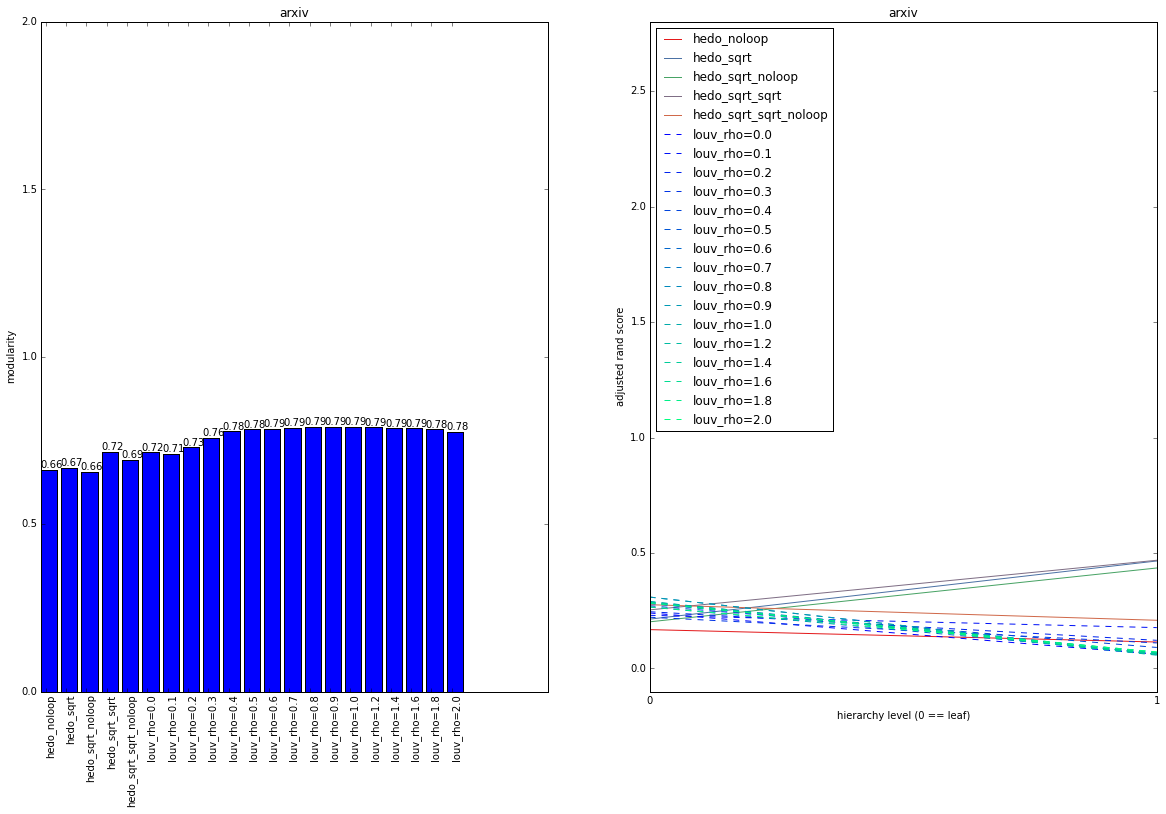

In [10]:
for idx,g in enumerate(sorted(graphs)):    
    fig = plt.figure(figsize=(20, 12))

    exp_name = g.split('/')[-1].replace('.bin', '')
    values = []
    for alg in algs:
        log_glob = glob.glob(g + '*' + alg + '.clusts.log')
        assert len(log_glob) == 1
        log_fpath = log_glob[0]
        values.append(get_peak_modularity(log_fpath))

    ax = fig.add_subplot(1, 2, 1)
    ax.bar(range(len(values)), values)
    ax.set_xticks(np.arange(len(values)) + 0.25)
    ax.set_xticklabels(algs)
    ax.set_ylim([0, 2.0])
    setp(ax.get_xticklabels(), rotation=90, ha="right",
         rotation_mode="anchor");
    title(exp_name);
    ylabel('modularity');
    for i, v in enumerate(values):
        ax.text(i, v + 0.005, '{:.2f}'.format(v))
    
    gtruth = load_clusterings(g + ".labels")
    values = []
    for alg in algs:
        clusts_glob = glob.glob(g + '*' + alg + '.clusts')
        assert len(clusts_glob) == 1
        cl_fpath = clusts_glob[0]
        clusts = load_clusterings(cl_fpath)
        values.append(np.asarray(score_clustering_best_match(clusts, gtruth)))
    
    ax = fig.add_subplot(1, 2, 2)
    for i, alg, v in zip(range(len(algs)), algs, values):
        ls = '--' if 'louv' in alg else '-'
        ax.plot(np.arange(len(v)), v + (i - len(algs)/2)*0.005, ls, label=alg, color=colors[alg])
    title(exp_name);
    xlabel('hierarchy level (0 == leaf)')
    ax.set_xticks(range(max([len(v) for v in values])))
    ylabel('adjusted rand score')
    ax.set_ylim([-0.1, 2.8])
    legend(loc='upper left');

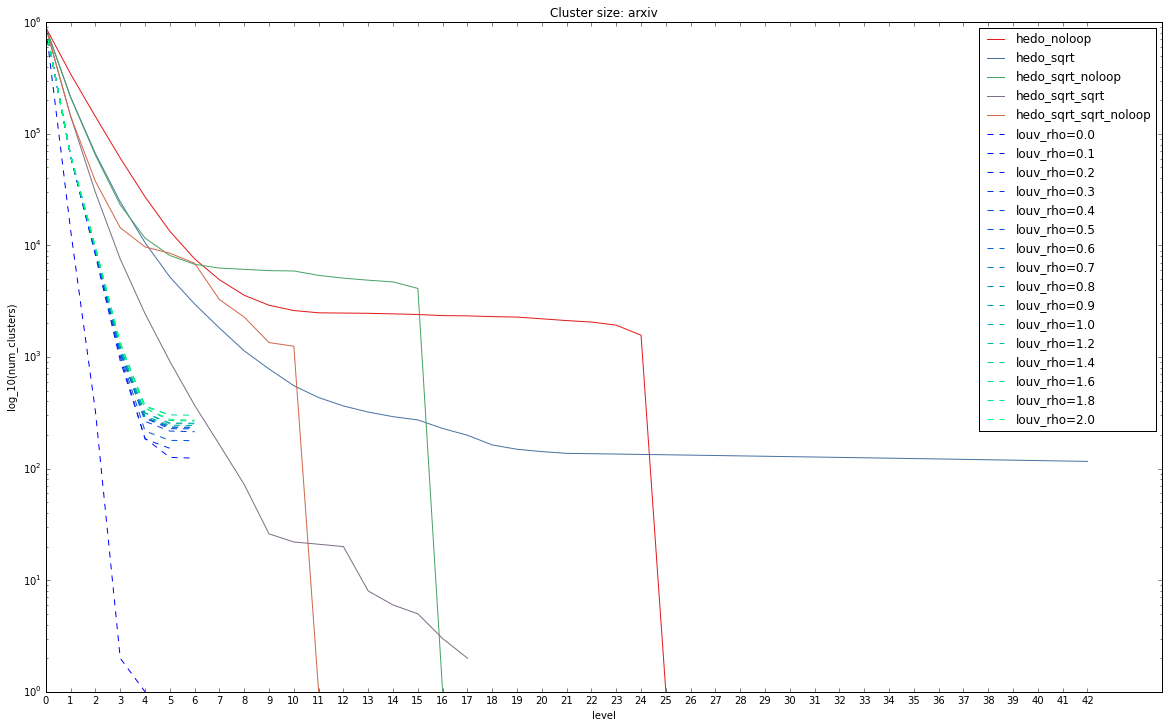

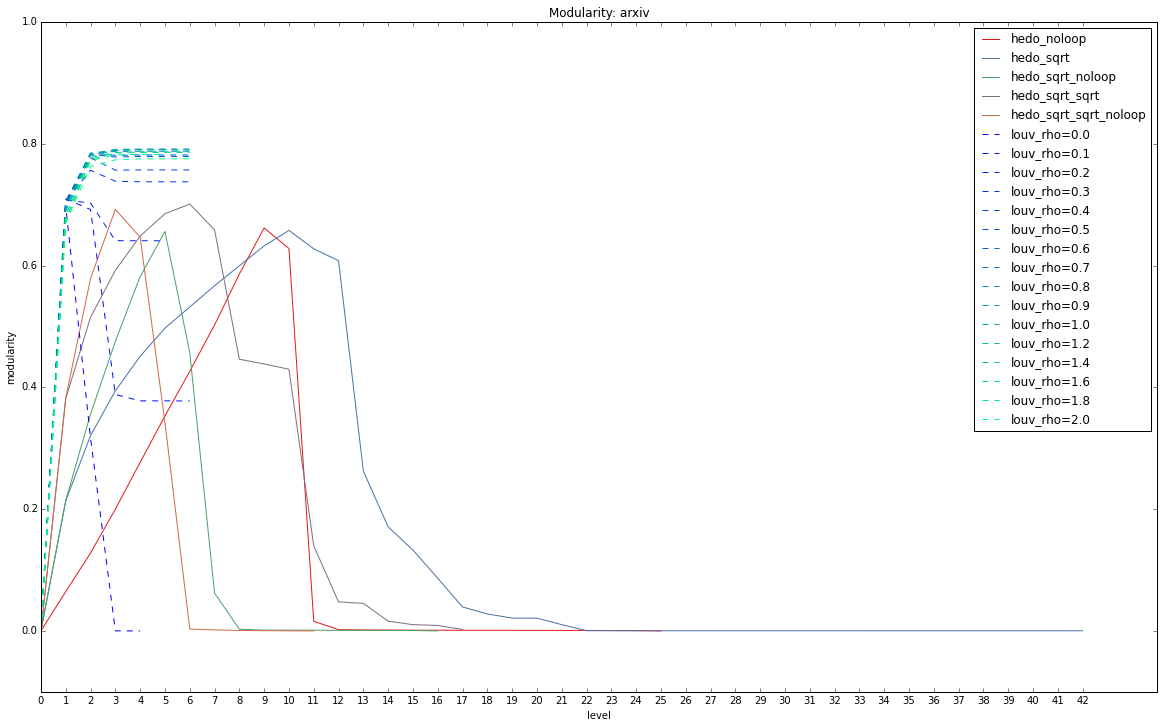

In [49]:
for idx,g in enumerate(sorted(graphs)):    
    fig = plt.figure(figsize=(20, 12))

    exp_name = g.split('/')[-1].replace('.bin', '')
    mod_values = []
    size_values = []
    for alg in algs:
        log_glob = glob.glob(g + '*' + alg + '.clusts.log')
        assert len(log_glob) == 1
        log_fpath = log_glob[0]
        sz, m = load_history(log_fpath)
        size_values.append(sz)
        mod_values.append(m)
        if any([f > 1.0 for f in m]):
            print alg
    
    ax = fig.add_subplot(1, 1, 1)
    for i, alg, v in zip(range(len(algs)), algs, size_values):
        ls = '--' if 'louv' in alg else '-'
        ax.semilogy(np.arange(len(v)), v, ls, label=alg, color=colors[alg])
    title('Cluster size: ' + exp_name);
    xlabel('level')
    ylabel('log_10(num_clusters)')
    ax.set_xticks(range(max([len(v) for v in size_values])))
    legend(loc='upper right');
    
    fig = plt.figure(figsize=(20, 12))
    ax = fig.add_subplot(1, 1, 1)
    for i, alg, v in zip(range(len(algs)), algs, mod_values):
        ls = '--' if 'louv' in alg else '-'
        ax.plot(np.arange(len(v)), v, ls, label=alg, color=colors[alg])
    title('Modularity: ' + exp_name);
    xlabel('level')
    ylabel('modularity')
    ax.set_ylim([-0.1, 1.0])
    ax.set_xticks(range(max([len(v) for v in mod_values])))
    legend(loc='upper right');

In [17]:
if 0:
    rand_scores = {}

In [ ]:
for idx,g in enumerate(sorted(graphs)):
    if g not in rand_scores:
        rand_scores[g] = {}
    gtruth = load_clusterings(g + ".labels")
    for R in range(10):
        print R
        for alg in algs:
            if (alg,R) not in rand_scores[g]:
                clusts_glob = glob.glob(g + '*' + alg + '.clusts' + '.R' + str(R))
                assert len(clusts_glob) == 1, ('%s %s %d' % (alg, R, len(clusts_glob)))
                cl_fpath = clusts_glob[0]
                clusts = load_clusterings(cl_fpath)
                rand_scores[g][(alg,R)] = np.asarray(score_clustering_best_match(clusts, gtruth))

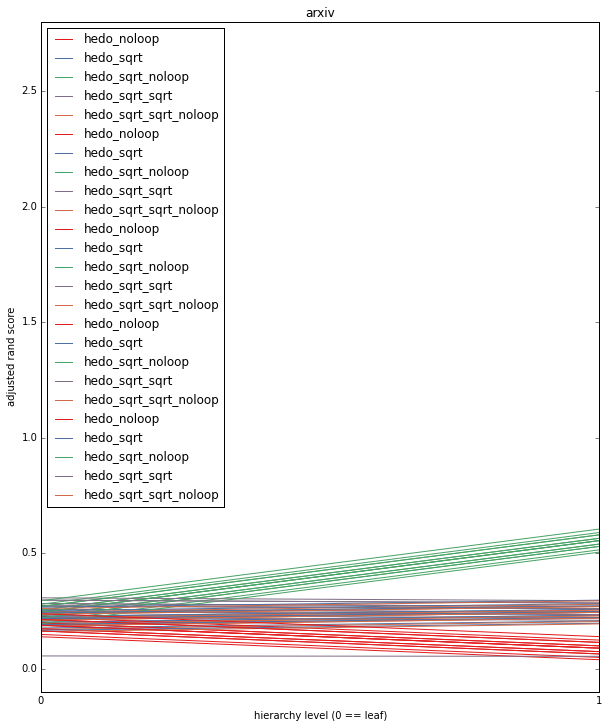

In [25]:
algs = [a for a in algs if 'louv' not in a]
r_algs = []
for idx,g in enumerate(sorted(graphs)):    
    fig = plt.figure(figsize=(10, 12))
    ax = fig.add_subplot(1, 1, 1)
    gtruth = load_clusterings(g + ".labels")
    values = []
    exp_name = g.split('/')[-1].replace('.bin', '')
    for R in range(5):
        for alg in algs:
            r_algs.append((alg, R))
            clusts_glob = glob.glob(g + '*' + alg + '.clusts' + '.R' + str(R))
            assert len(clusts_glob) == 1, ('%s %s %d' % (alg, R, len(clusts_glob)))
            cl_fpath = clusts_glob[0]
            clusts = load_clusterings(cl_fpath)
            values.append(rand_scores[g][(alg, R)])
            # np.asarray(score_clustering_best_match(clusts, gtruth)))

        for i, (alg, r), v in zip(range(len(r_algs)), r_algs, values):
            ls = '--' if 'louv' in alg else '-'
            ax.plot(np.arange(len(v)), v + (i - len(r_algs)/2)*0.005, ls, label=(alg if r == 0 else None), color=colors[alg])
        title(exp_name);
        xlabel('hierarchy level (0 == leaf)')
        ax.set_xticks(range(max([len(v) for v in values])))
        ylabel('adjusted rand score')
        ax.set_ylim([-0.1, 2.8])
        legend(loc='upper left');